# VAR Model

Vector autoregressive models are used for multivariate time series analysis and forecasting.<br>
It works by looking back at a window of past observations for every variable in order to create <br>
a linear regression model for the prediction of each variable. For instance, a VAR model that has<br>
7 variables will create 7 different models, one for the forecasting of each variable. 

In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [2]:
# import data
stationary = pd.read_csv('stationary_data_all.csv', index_col = 0)
stationary.tail()

,price,volatility,volume_price,volume_number,positive_comment,neutral_comment,negative_comment
date,,,,,,,
2018-08-27,0.025081,-0.002355,0.184100,10112.897380,0.040822,0.230524,-0.005098
2018-08-28,-0.005569,-0.009268,-0.314563,-18284.433401,0.134119,0.004890,0.005098
2018-08-29,-0.007578,0.008958,0.177887,10291.165226,-0.017644,0.101940,0.118160
2018-08-30,0.004021,-0.008727,-0.197760,-11108.489051,-0.074994,-0.226453,-0.073413
2018-08-31,0.024807,0.006655,-0.150660,-7995.968267,-0.010210,0.119623,-0.029607


## train and fit var model

In [3]:
# stationary index to datetime
stationary.index = pd.DatetimeIndex(stationary.index).date

In [4]:
# pick start date for your analysis
# look at last step and see when data starts to be consistent
start_date = dt.date(2012, 1, 1)
stationary = stationary[start_date : ]
stationary.head()

,price,volatility,volume_price,volume_number,positive_comment,neutral_comment,negative_comment
2012-01-01,0.110222,-0.002509,-0.075204,-21379.908661,-1.386294,0.000000,-1.178655
2012-01-02,-0.009533,-0.038630,-0.428344,-35908.217191,1.435085,0.693147,1.178655
2012-01-03,-0.067352,0.002795,0.541285,57845.190315,0.213574,-1.791759,0.325422
2012-01-04,0.132250,0.039409,0.106451,-3231.522059,0.325422,0.693147,-0.492476
2012-01-05,0.221347,0.066854,0.495694,39031.992044,-0.492476,0.693147,0.241162


In [5]:
# create train data (80/20 split)
train = stationary[ : int(0.8*(len(stationary)))].copy()

In [6]:
# create VAR model on train data
model = VAR(endog = train)

C:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [7]:
# see the different lag order suggestions to pick your information criterion
print(model.select_order(trend = 'c'))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 15, BIC -> 5, FPE -> 15, HQIC -> 6>


In [8]:
# fit model to train data
# model_fit is a VARResultsWrapper object
model_fit = model.fit(ic = 'aic', trend = 'c')
# number of lags
num_lag = model_fit.k_ar
num_lag

15

In [9]:
# model_fit summary
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 29, Dec, 2018
Time:                     22:53:36
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   0.264819
Nobs:                     1933.00    HQIC:                  -1.08609
Log likelihood:          -16648.3    FPE:                   0.153925
AIC:                     -1.87206    Det(Omega_mle):        0.105928
--------------------------------------------------------------------
Results for equation price
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.002585         0.001350            1.915           0.056
L1.price                    -0.022771         0.027219           -0.837           0.403
L1.volatility               -0.1

In [10]:
# example one day forecast into the future using train data
## IMPORTANT = data has to be in ndarray format. use '.values' on y argument ##
model_fit.forecast(y = train.values, steps = 1)

array([[ 3.68503552e-03, -8.29092075e-03, -1.77123395e-01,
        -1.30485052e+04, -3.00442209e-02, -3.59153915e-03,
         1.24680617e-01]])

# create var functions

In [11]:
# create function so that we can iterate model_fit.forecast() over test data
# VAR also has the method 'predict' but it doesn't work so we have to do this the hard way

def predict(data, fitted_model, lag_order, predict_steps):
    # empty list for our predictions
    prediction = []
  
    # for loop to iterate fitted_model over data
    for i in range(lag_order, len(data)):
        # window of lagged data that the model uses to predict next observation
        window = data.iloc[i - lag_order : i].copy()
        # results of fitted_model being applied to window
        results = fitted_model.forecast(y = window.values, steps = predict_steps)
        # append results to prediction list
        prediction.append(results)
        
    # convert prediction (which is a list of numpy arrays) to a dataframe
    df = np.vstack(prediction)
    df = pd.DataFrame(df)
    # df column names from data
    df.columns = list(data.columns)
    # df index from data
    df.index = data.iloc[len(data) - len(prediction) :].index
    
    # return df
    return df

In [12]:
# create error functions

# root mean squared error
def rmse(predicted, actual):
    # formula for rmse
    residual = predicted - actual
    residual_sq = residual ** 2
    mean_sq = np.mean(residual_sq)
    rmse_value = np.sqrt(mean_sq)
    # return rmse_value
    return rmse_value

# mean absolute error
def mae(predicted, actual):
    # formula for mae
    absolute_residual = np.absolute(predicted - actual)
    mae_value = np.mean(absolute_residual)
    # return mae_value
    return mae_value

In [13]:
# function that returns lineplot of predicted vs actual data w/ rmse and mae, and histograph of the residual

def model_graphs(predicted, actual, title = str):
    # RMSE
    rmse_value = rmse(predicted = predicted, actual = actual)
    # MAE
    mae_value = mae(predicted = predicted, actual = actual)
    # start_year (for putting in text box)
    start_year = predicted.iloc[ : 1].index.copy()
    # text box in line plot
    text_str = 'RMSE = ' + str(rmse_value) + '\n MAE = ' + str(mae_value)
    # line plot
    plt.figure(1)
    plt.plot(actual, color = 'blue', linewidth = 2, label = 'actual')
    plt.plot(predicted, color = 'red', linewidth = 1, label = 'predicted')
    plt.legend()
    plt.title(title + ' Actual vs Predicted')
    plt.text(x = start_year, y = 0.2, s = text_str)
    # residual & hist
    plt.figure(2)
    residual = actual - predicted
    plt.hist(residual, bins = 200)
    plt.title('Distribution of ' + title + ' residual')
    plt.axvline(residual.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
    # show graphics
    plt.show()

In [14]:
# function classifies price movement each day as either going up(if positive) or down(negative)
def category(x):
    if x >= 0:
        return 'up'
    elif x < 0:
        return 'down'

# function that returns confusion matrix of model with metrics
def confusion_matrix(predicted, actual, title = str):
    df = pd.DataFrame()
    df['predicted'] = predicted.apply(category)
    df['actual'] = actual.apply(category)
    # code
    df.loc[(df['predicted'] == 'up') & (df['actual'] == 'up'), 'code'] = 'true_positive'
    df.loc[(df['predicted'] == 'up') & (df['actual'] == 'down'), 'code'] = 'false_positive'
    df.loc[(df['predicted'] == 'down') & (df['actual'] == 'down'), 'code'] = 'true_negative'
    df.loc[(df['predicted'] == 'down') & (df['actual'] == 'up'), 'code'] = 'false_negative'
    # confusion dictionary
    z = dict(df['code'].value_counts())
    # confusion metrics
    accuracy = (z['true_positive'] + z['true_negative']) / (z['true_positive'] + z['true_negative'] + z['false_positive'] + z['false_negative'])
    true_positive_rate = z['true_positive'] / (z['true_positive'] + z['false_negative'])
    false_positive_rate = z['false_positive'] / (z['false_positive'] + z['true_negative'])
    true_negative_rate = z['true_negative'] / (z['true_negative'] + z['false_positive'])
    false_negative_rate = z['false_negative'] / (z['false_negative'] + z['true_positive'])
    # print metrics
    print('\nMetrics for [{0}]\nAccuracy:{1:6.3f} \nTP Rate:{2:7.3f} \nFP Rate:{3:7.3f}\nTN Rate:{4:7.3f} \nFN Rate:{5:7.3f}'.format(str(title), accuracy, true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate))
    # print confusion matrix graph
    print('\n'+
      '            [{title}] Confusion Matrix\n'.format(title = str(title))+
      '\n'+
      '           |-------------|-------------|\n'+
      '  n= {0}  | Predicted:  | Predicted:  |\n'.format(z['true_positive']+z['false_positive']+z['true_negative']+z['false_negative'])+
      '           |    Down     |    Up       |\n'+
      '|----------|-------------|-------------|------------|\n'+
      '| Actual:  |             |             |            |\n'+
      '|  Down    |  tn: {0}    |  fp: {1}    |    {2}     |\n'.format(z['true_negative'], z['false_positive'], z['true_negative']+z['false_positive'])+
      '|----------|-------------|-------------|------------|\n'+
      '| Actual:  |             |             |            |\n'+
      '|   UP     |  fn: {0}    |  tp: {1}    |    {2}    |\n'.format(z['false_negative'], z['true_positive'] ,z['false_negative']+z['true_positive'])+
      '|----------|-------------|-------------|------------|\n'+
      '           |             |             |\n'+
      '           |      {0}    |      {1}   |\n'.format(z['true_negative']+z['false_negative'], z['false_positive']+z['true_positive'])+
      '           |-------------|-------------|\n')
    # return df
    return df

# var model results

- ## train

In [15]:
# train results
train_predicted = model_fit.fittedvalues.copy()
train_actual = train.iloc[num_lag : len(train)]

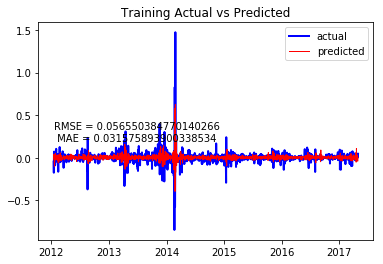

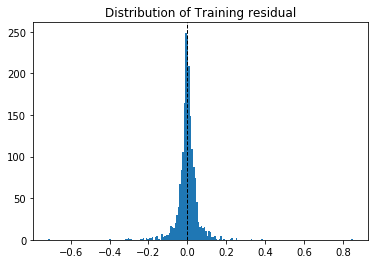

In [16]:
# graphs
model_graphs(predicted = train_predicted['price'], actual = train_actual['price'], title = 'Training')

In [17]:
# confusion matrix
train_confusion = confusion_matrix(predicted = train_predicted['price'], actual = train_actual['price'], title = 'Train')


Metrics for [Train]
Accuracy: 0.553 
TP Rate:  0.610 
FP Rate:  0.516
TN Rate:  0.484 
FN Rate:  0.390

            [Train] Confusion Matrix

           |-------------|-------------|
  n= 1933  | Predicted:  | Predicted:  |
           |    Down     |    Up       |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|  Down    |  tn: 421    |  fp: 449    |    870     |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|   UP     |  fn: 415    |  tp: 648    |    1063    |
|----------|-------------|-------------|------------|
           |             |             |
           |      836    |      1097   |
           |-------------|-------------|



- ## test

In [18]:
# test results
# test_lag contains the last 'num_lag' number of observations of the training data in order to make the forecast for the first "real" test observation
test_lag = stationary.iloc[len(train) - num_lag :]
test_predicted = predict(data = test_lag, fitted_model = model_fit, lag_order = num_lag, predict_steps = 1)
test_actual = stationary.iloc[len(train) :]

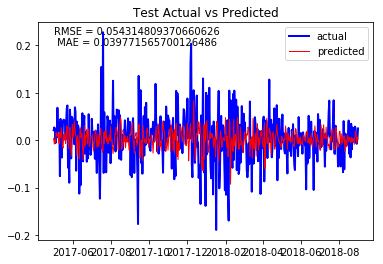

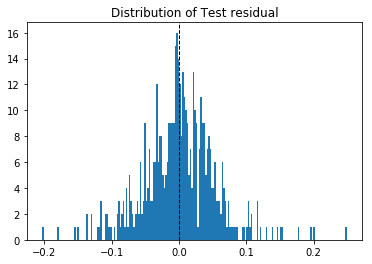

In [19]:
# graphs
model_graphs(predicted = test_predicted['price'], actual = test_actual['price'], title = 'Test')

In [20]:
# confusion matrix
test_confusion = confusion_matrix(predicted = test_predicted['price'], actual = test_actual['price'], title = 'Test')


Metrics for [Test]
Accuracy: 0.527 
TP Rate:  0.592 
FP Rate:  0.552
TN Rate:  0.448 
FN Rate:  0.408

            [Test] Confusion Matrix

           |-------------|-------------|
  n= 488  | Predicted:  | Predicted:  |
           |    Down     |    Up       |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|  Down    |  tn: 100    |  fp: 123    |    223     |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|   UP     |  fn: 108    |  tp: 157    |    265    |
|----------|-------------|-------------|------------|
           |             |             |
           |      208    |      280   |
           |-------------|-------------|



- ## persistent model

In [21]:
# persistent model data over test data
persistent_predicted = stationary.shift(1)
persistent_predicted = persistent_predicted.iloc[len(train) : ]
persistent_actual = test_actual.copy()

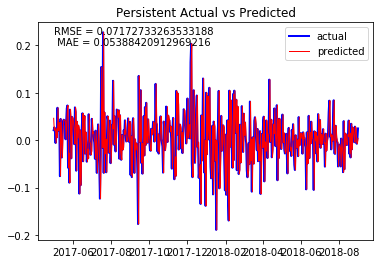

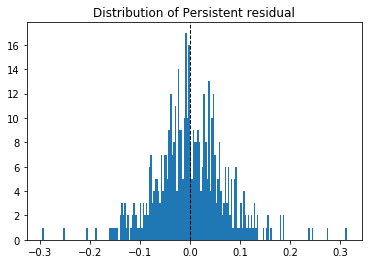

In [22]:
# graphs
model_graphs(predicted = persistent_predicted['price'], actual = persistent_actual['price'], title = 'Persistent')

In [23]:
# confusion matrix
persistent_confusion = confusion_matrix(predicted = persistent_predicted['price'], actual = persistent_actual['price'], title = 'Persistent')


Metrics for [Persistent]
Accuracy: 0.500 
TP Rate:  0.540 
FP Rate:  0.547
TN Rate:  0.453 
FN Rate:  0.460

            [Persistent] Confusion Matrix

           |-------------|-------------|
  n= 488  | Predicted:  | Predicted:  |
           |    Down     |    Up       |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|  Down    |  tn: 101    |  fp: 122    |    223     |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|   UP     |  fn: 122    |  tp: 143    |    265    |
|----------|-------------|-------------|------------|
           |             |             |
           |      223    |      265   |
           |-------------|-------------|

